# Analysis of Brazilian exports 

In [224]:
using CSV
using LinearAlgebra
using Plots
using StatsBase
using Statistics
using DataFrames
using Dates
using Pipe
using StatsPlots
using LaTeXStrings

In [225]:
ENV["COLS"]=12;
ENV["LINES"] = 10;

In [226]:
dcom=CSV.read("data_comexstat.csv");
first(dcom, 5)

,date,product,state,country,type,route,tons,usd
,Date,String,String,String,String,String,Float64,Float64
1,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
2,1997-01-01,corn,GO,Argentina,Import,Ground,54.0,36720.0
3,1997-01-01,corn,GO,Bolivia,Export,Ground,0.2,180.0
4,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
5,1997-01-01,corn,MG,Argentina,Import,Ground,27.0,18630.0


In [227]:
size(dcom)

(117965, 8)

In [228]:
#Filtering and grouping by porduct

dcom_exports=@pipe filter(:type=>x->x=="Export",dcom) |> transform(_, :date=>x->Year.(x) .+ Month.(x) .+ Date(0))
gp=groupby(dcom_exports,:product);
first(gp[(product="soybeans",)],5)

,date,product,state,country,type,route,tons,usd,date_function
,Date,String,String,String,String,String,Float64,Float64,Date
1,1997-01-01,soybeans,GO,Spain,Export,Sea,13730.0,3.95424e6,1997-02-01
2,1997-01-01,soybeans,MT,Bolivia,Export,Other,100.0,60500.0,1997-02-01
3,1997-01-01,soybeans,RS,Argentina,Export,Ground,200.0,104000.0,1997-02-01
4,1997-02-01,soybeans,GO,Netherlands,Export,Sea,3000.0,855450.0,1997-03-01
5,1997-02-01,soybeans,MT,Netherlands,Export,Sea,5000.0,1.43618e6,1997-03-01


In [229]:
soybeans=gp[(product="soybeans",)];
soyoil=gp[(product="soybean_oil",)];
soymeal=gp[(product="soybean_meal",)];

In [230]:
soybeans

,date,product,state,country,type,route,tons,usd,date_function
,Date,String,String,String,String,String,Float64,Float64,Date
1,1997-01-01,soybeans,GO,Spain,Export,Sea,13730.0,3.95424e6,1997-02-01
2,1997-01-01,soybeans,MT,Bolivia,Export,Other,100.0,60500.0,1997-02-01
3,1997-01-01,soybeans,RS,Argentina,Export,Ground,200.0,104000.0,1997-02-01
4,1997-02-01,soybeans,GO,Netherlands,Export,Sea,3000.0,855450.0,1997-03-01
5,1997-02-01,soybeans,MT,Netherlands,Export,Sea,5000.0,1.43618e6,1997-03-01
6,1997-02-01,soybeans,PR,Cuba,Export,Sea,305.0,87840.0,1997-03-01
7,1997-02-01,soybeans,PR,Netherlands,Export,Sea,8790.0,2.51667e6,1997-03-01
8,1997-03-01,soybeans,GO,Netherlands,Export,Sea,5825.0,1.65624e6,1997-04-01
9,1997-03-01,soybeans,GO,Netherlands,Export,Sea,6455.73,1.86263e6,1997-04-01


In [270]:
function totalSumCol(sgp, col, p, product)
   totalSum=@pipe sgp |> groupby(_, :date_function) |> combine(_, col=>sum)
    plot!(p, totalSum.date_function,totalSum[:, 2], yaxis=:log, label=product, legend=:outerbottomright,
    ylabel="Tons(log10)")
end

function totalSumColYear(sgp, col, p, product)
   totalSum=@pipe sgp |> transform(_, :date=>x->Year.(x) .+ Date(0)) |> 
    groupby(_, :date_function) |>
    combine(_, col=>sum)
     
    plot!(p, totalSum.date_function, totalSum[:, 2], 
        yaxis=:log, label=product, legend=:outerbottomright,
    ylabel="Tons(log10)", xrotation=60)
    
    return totalSum[:,2]
end

totalSumColYear (generic function with 1 method)

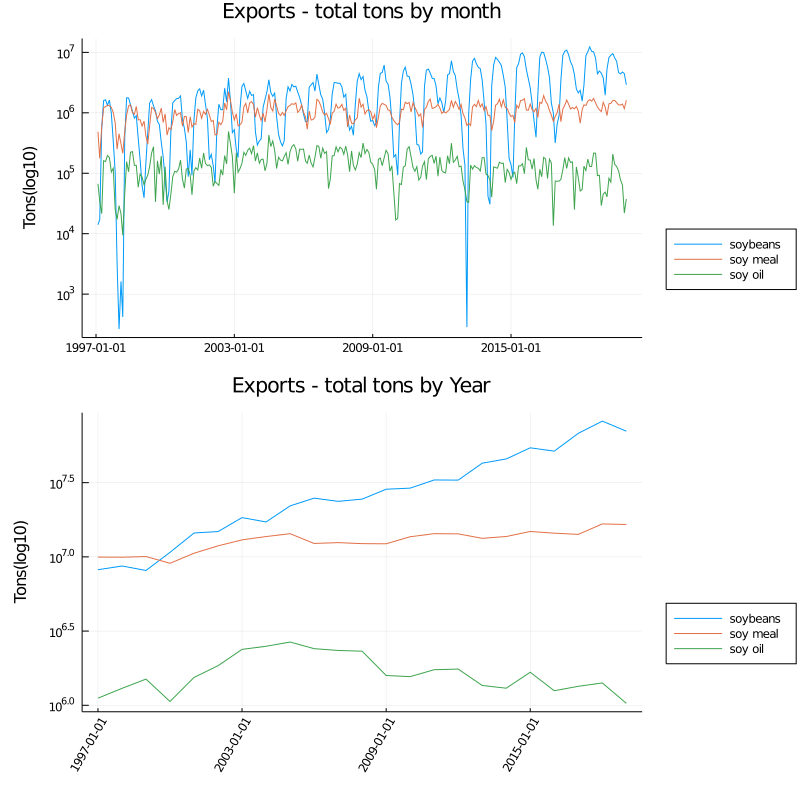

In [232]:
p1=plot()
totalSumCol(soybeans, "tons", p1, "soybeans")
totalSumCol(soymeal, "tons", p1, "soy meal")
totalSumCol(soyoil, "tons", p1, "soy oil")
title!("Exports - total tons by month")

p2=plot()
totalSumColYear(soybeans, "tons", p2, "soybeans")
totalSumColYear(soymeal, "tons", p2, "soy meal")
totalSumColYear(soyoil, "tons", p2, "soy oil")
title!("Exports - total tons by Year")

plot(p1,p2, layout=(2,1), size=(800, 800))

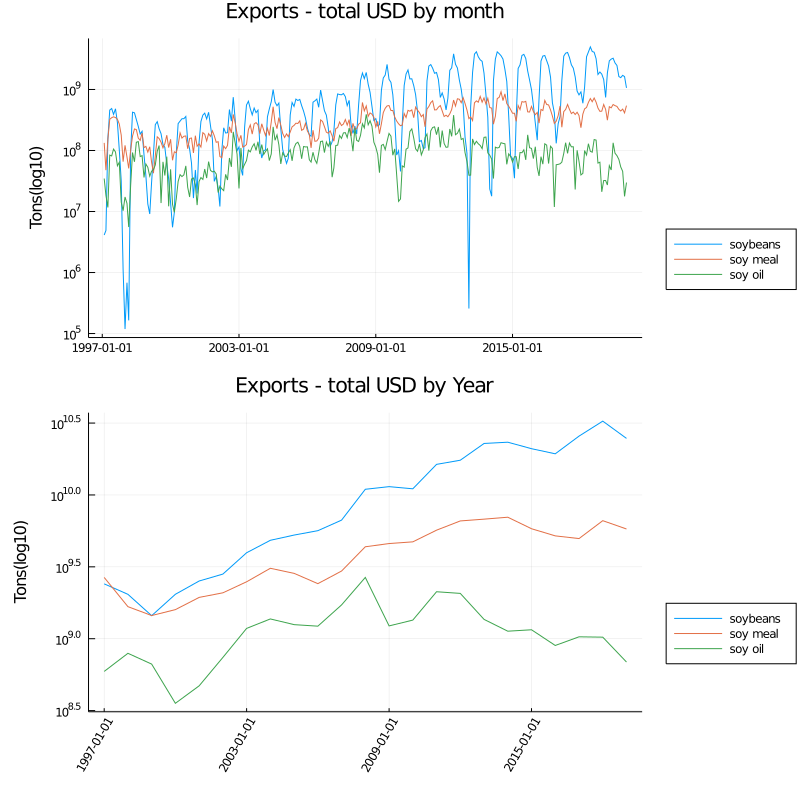

In [233]:
p1=plot()
totalSumCol(soybeans, "usd", p1, "soybeans")
totalSumCol(soymeal, "usd", p1, "soy meal")
totalSumCol(soyoil, "usd", p1, "soy oil")
title!("Exports - total USD by month")

p2=plot()
totalSumColYear(soybeans, "usd", p2, "soybeans")
totalSumColYear(soymeal, "usd", p2, "soy meal")
totalSumColYear(soyoil, "usd", p2, "soy oil")
title!("Exports - total USD by Year")

plot(p1,p2, layout=(2,1), size=(800, 800))

## Most important products in the last 5 years
The most important products should be the ones that give more value, so we are going to filter, group and than sort by value to see what are they

In [234]:
maxDate=max(collect(dcom.date)...)
minDate=maxDate-Year(5)

d_last5=filter(x->(x.date.>minDate) .& (x.type.=="Export"), dcom)
last(d_last5,5)

,date,product,state,country,type,route,tons,usd
,Date,String,String,String,String,String,Float64,Float64
1,2019-12-01,wheat,PR,United States,Export,Sea,0.4,400.0
2,2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.0,6.963e6
3,2019-12-01,wheat,SP,Ireland,Export,Sea,0.5,477.0
4,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0
5,2019-12-01,wheat,SP,Marshall Islands,Export,Other,0.01,85.0


In [235]:
gpd5=@pipe d_last5 |> groupby(_, :product) |> combine(_, :usd => sum) |> sort(_, :usd_sum, rev=true) 
gpd5

,product,usd_sum
,String,Float64
1,soybeans,1.23326e11
2,sugar,4.09385e10
3,soybean_meal,2.84077e10
4,corn,2.44477e10
5,soybean_oil,4.79595e9
6,wheat,7.26945e8


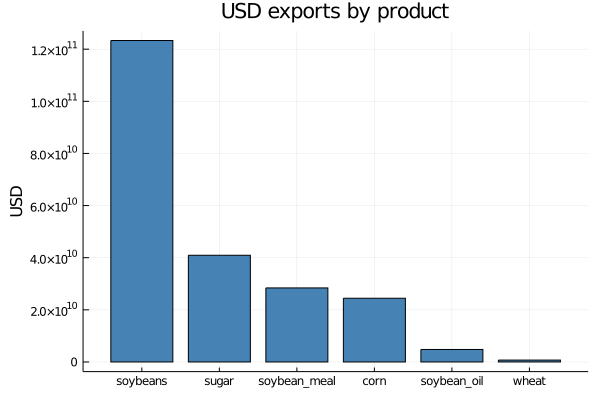

In [236]:
bar(gpd5.product, gpd5.usd_sum, label=nothing, fill=:steelblue, ylabel="USD")
title!("USD exports by product")

## We will now analyse the routes in the last few years
I will be using tons this time and as how much is "few years" was not told, it will be the same 5 years

In [237]:
total_routes=@pipe d_last5 |> groupby(_, [:product, :route]) |> combine(_, :tons=>sum)

,product,route,tons_sum
,String,String,Float64
1,corn,Sea,1.38381e8
2,corn,Ground,72509.5
3,corn,Other,266055.0
4,corn,River,5.86963e6
5,corn,Air,10152.6
6,soybean_meal,Sea,7.65254e7
7,soybean_meal,Ground,8336.7
8,soybean_oil,Sea,6.55397e6
9,soybean_oil,Ground,129906.0


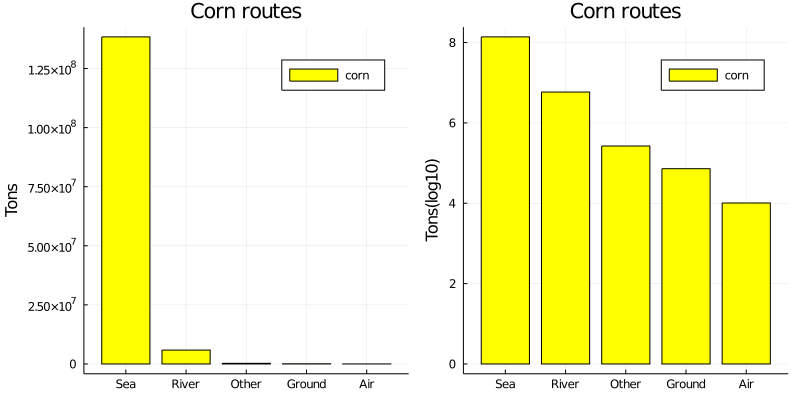

In [238]:
total_corn=filter(x->x.product=="corn",total_routes);
sort!(total_corn, :tons_sum, rev=true)
p1=bar(total_corn.route, total_corn.tons_sum, fill=:yellow, label="corn", ylabel="Tons")
p2=bar(total_corn.route, log10.(total_corn.tons_sum), fill=:yellow, label="corn", ylabel="Tons(log10)")
plot(p1,p2, layout=2, size=(800, 400))
title!("Corn routes")

## Corn conclusion
We can see that by far the most important route is the sea for corn

In [239]:
using StatsPlots

In [240]:
groupBar=unstack(total_routes, :product, :route, :tons_sum)
replace!(groupBar.River, missing=>1)
groupBar

,product,Air,Ground,Other,River,Sea
,String,Float64?,Float64?,Float64?,Float64?,Float64?
1,corn,10152.6,72509.5,266055.0,5.86963e6,1.38381e8
2,soybean_meal,22024.4,8336.7,91497.2,197.4,7.65254e7
3,soybean_oil,2.589,129906.0,24137.5,3409.91,6.55397e6
4,soybeans,53.898,98344.1,1.51902e6,8.56609e6,3.16148e8
5,sugar,30.179,629632.0,47848.9,46786.3,1.19309e8
6,wheat,1.059,1491.14,11.482,1.0,3.88433e6


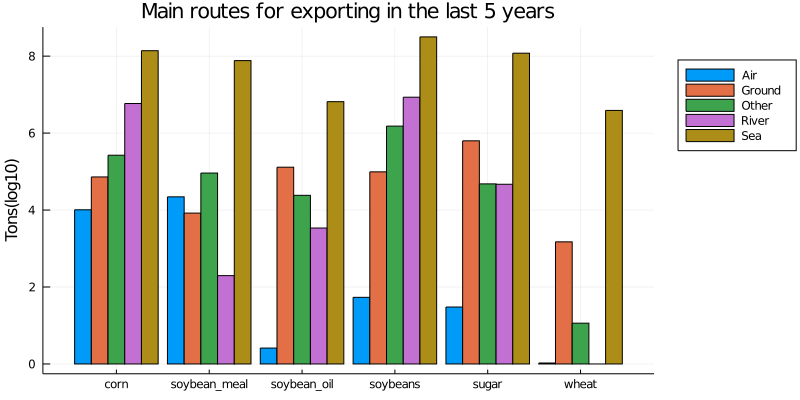

In [241]:
legendGroup=reshape(names(groupBar)[2:end], (1,5))

groupedbar(groupBar[:,1],log10.(Matrix(groupBar[:,2:end])), 
    bar_width=.9, label=legendGroup, legend = :outertopright,
    size=(800, 400), ylabel="Tons(log10)")

title!("Main routes for exporting in the last 5 years")

## Conclusion

We can see that the most important route for all products is the sea, and the alternative routes vary a little with the product. 

## Trade Partners for corn and sugar in the last 3 years

We are going to follow a similar analysis to find the partners. Filtering, grouping and operating the data

In [242]:
#Filtering
maxDate=max(collect(dcom.date)...)
minDate=maxDate-Year(3)

d_last3=filter(x->(x.date.>minDate) .& (x.type.=="Export"), dcom)
first(d_last3,5)

,date,product,state,country,type,route,tons,usd
,Date,String,String,String,String,String,Float64,Float64
1,2017-01-01,corn,GO,Dominican Republic,Export,Sea,795.679,147710.0
2,2017-01-01,corn,GO,Ecuador,Export,Air,0.122,1504.0
3,2017-01-01,corn,GO,Egypt,Export,Sea,199.95,533884.0
4,2017-01-01,corn,GO,Iran,Export,Sea,17.68,2791.0
5,2017-01-01,corn,GO,Iran,Export,Sea,600.0,85626.0


In [243]:
gp3=@pipe d_last3 |> groupby(_, [:product, :country]) |> combine(_, :usd=>sum) |> groupby(_, :product)

,product,country,usd_sum
,String,String,Float64
1,corn,Dominican Republic,3.34572e8
2,corn,Ecuador,1.03915e7
3,corn,Egypt,1.37507e9
4,corn,Iran,2.82234e9
5,corn,Malaysia,6.96334e8
6,corn,Paraguay,9.46351e7
7,corn,South Africa,1.53148e7
8,corn,Trinidad and Tobago,1.29204e6
9,corn,United Arab Emirates,5.66287e7


In [244]:
sugar3=sort(DataFrame(gp3[("sugar",)]), :usd_sum, rev=true)
corn3=sort(DataFrame(gp3[("corn",)]), :usd_sum, rev=true)

,product,country,usd_sum
,String,String,Float64
1,corn,Iran,2.82234e9
2,corn,Japan,1.57498e9
3,corn,Vietnam,1.55104e9
4,corn,Egypt,1.37507e9
5,corn,Spain,1.33577e9
6,corn,South Korea,1.02457e9
7,corn,Taiwan,8.15565e8
8,corn,Malaysia,6.96334e8
9,corn,Bangladesh,5.27879e8


## Above there is a plot showing the most important corn and sugar partners 

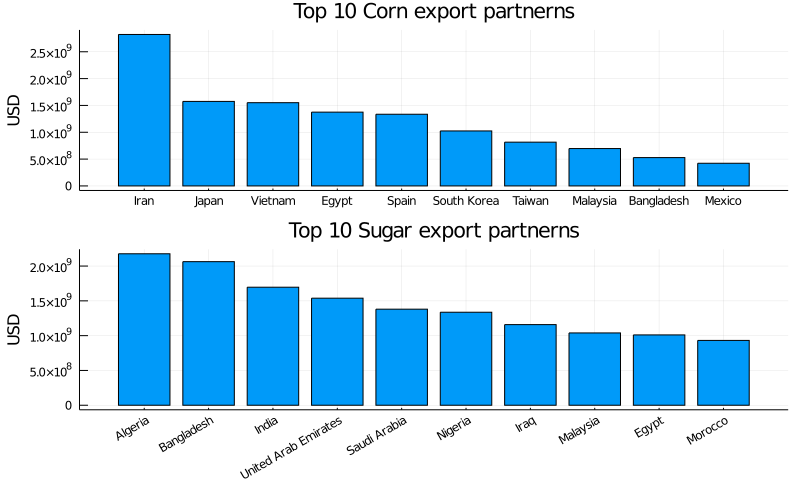

In [245]:
p1=bar(corn3[1:10,:country], corn3[1:10,:usd_sum], label=nothing, ylabel="USD")
title!("Top 10 Corn export partnerns")
p2=bar(sugar3[1:10,:country], sugar3[1:10,:usd_sum], xrotation=30, label=nothing, ylabel="USD")
title!("Top 10 Sugar export partnerns")
plot(p1,p2, layout=(2,1), size=(800, 500))

## For each product we are now going to find the five most important states 

The criteria will be again tons exported

In [246]:
#filtering
statesAll=@pipe filter(x-> x.type.=="Export", dcom) |> groupby(_, [:product, :state]) |> 
    combine(_, :tons=>sum) |> sort(_, [:product, :tons_sum], rev=true) |> groupby(_, :product)

,product,state,tons_sum
,String,String,Float64
1,wheat,RS,6.73498e6
2,wheat,PR,824975.0
3,wheat,SC,81340.9
4,wheat,SP,10066.8
5,wheat,MS,910.108
6,wheat,MG,217.911
7,wheat,GO,39.782
8,wheat,RJ,23.637
9,wheat,RO,1.87


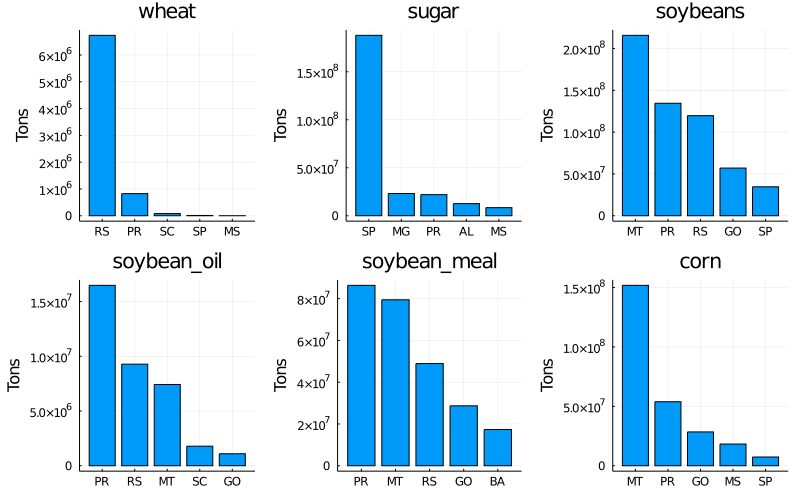

In [247]:
myPlots=[]
for g in statesAll
    p=bar(g.state[1:5], g.tons_sum[1:5], label=nothing, title=g[1,1], ylabel="Tons")
    push!(myPlots, p)
end

plot(myPlots..., layout=length(myPlots), size=(800,500))

## Considerations about the last challenge

Given this variables, I will do a very simple linear regression of classical type `A x = b` to try to predict the next outcomes

In [323]:
using XLSX

I only have the data from 1997 to now, so I will drop the other years for now

In [324]:
covariates=@pipe XLSX.readtable("covariates.xlsx", "Sheet1") |> DataFrame(_...) |> dropmissing(_) |> filter(x->x.year.>=1997,_)
covariates23=covariates[1:23,:]

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands
,Any,Any,Any,Any,Any,Any,Any
1,1997,105.762,93.2042,124.013,560.723,106.976,152.738
2,1998,84.16,80.8314,77.4217,604.459,109.009,159.917
3,1999,65.9287,71.8239,67.6017,651.002,109.336,167.913
4,2000,68.9938,70.1735,82.9349,706.338,116.88,174.965
5,2001,63.6051,71.2791,80.0291,765.67,117.815,178.989
6,2002,71.1854,79.0141,81.5221,835.346,129.95,179.347
7,2003,87.8905,83.7169,95.1138,918.881,141.905,179.706
8,2004,104.265,89.0062,113.941,1012.61,147.582,183.3
9,2005,84.1074,78.3574,91.1802,1128.04,155.108,186.966


`A` will be a matrix with the features from the covariates dataset

In [325]:
A=Matrix{Float64}(covariates23[1:end,:])

23×13 Array{Float64,2}:
 1997.0  105.762    93.2042  124.013   …  173.937  218.684  180.134   299.095
 1998.0   84.16     80.8314   77.4217     178.459  235.085  178.152   316.443
 1999.0   65.9287   71.8239   67.6017     184.883  249.425  177.618   331.632
    ⋮                                  ⋱             ⋮               
 2018.0  129.102   130.859   165.415      380.051  561.475  210.699  1129.19
 2019.0  123.25    135.36    148.244      391.072  592.918  212.174  1208.23

`b` is a matrix with the exports in tons

In [326]:
soybeans_tons=totalSumColYear(soybeans, "tons", plot(), "soybean")
soymeal_tons=totalSumColYear(soymeal, "tons", plot(), "soybean")
soyoil_tons=totalSumColYear(soyoil, "tons", plot(), "soybean")

b=[soybeans_tons soymeal_tons soyoil_tons]

23×3 Array{Float64,2}:
 8.19503e6  9.96595e6  1.11745e6
 8.67949e6  9.94788e6  1.30008e6
 8.09604e6  1.00501e7  1.50153e6
 ⋮                     
 8.21474e7  1.667e7    1.41436e6
 7.03001e7  1.65304e7  1.03129e6

In [327]:
#Solving the regression
x=A\b

13×3 Array{Float64,2}:
  -17860.3    13384.2       4569.65
 -423464.0     -128.503    22197.2
  108355.0    10768.9      -5940.64
       ⋮                 
  572417.0  -250081.0    -128776.0
   94083.4    74281.7       5836.13

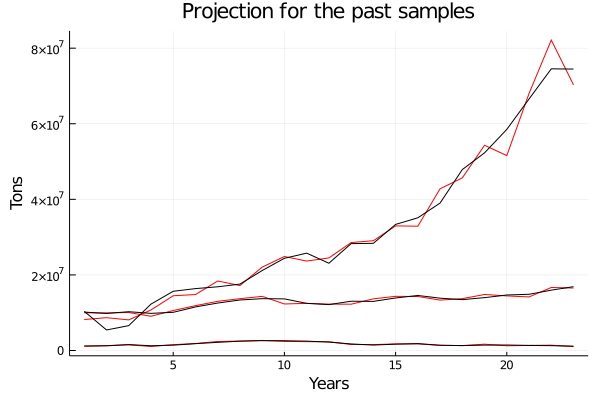

In [328]:
plot(b, label=nothing, color=:red)
plot!(A*x, legend=:bottomright, label=nothing, xlabel="Years", ylabel="Tons", color=:black)
title!("Projection for the past samples")

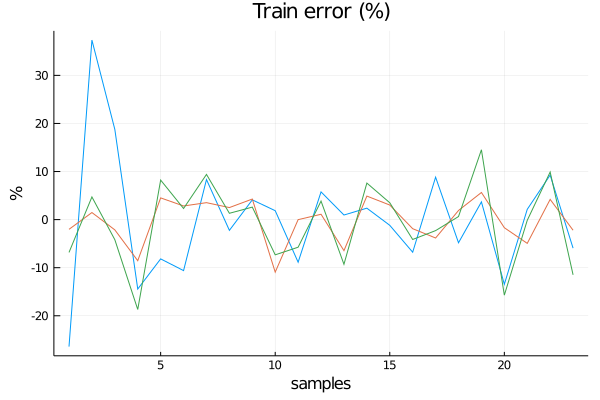

In [339]:
#Error
plot((b-A*x)./b*100, title="Train error (%)", label=nothing, xlabel="samples", ylabel="%")

## Forecasting using the covariates data

In [329]:
future_data=covariates[24:end,:]

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands
,Any,Any,Any,Any,Any,Any,Any
1,2020,116.921,127.346,145.244,3685.67,169.95,211.249
2,2021,121.166,130.856,148.695,4024.75,175.218,217.587
3,2022,125.566,134.463,152.228,4230.01,181.267,220.415
4,2023,130.125,138.17,155.846,4441.51,187.577,223.722
5,2024,134.85,141.979,159.549,4663.59,194.212,227.301
6,2025,139.747,145.893,163.34,4892.1,201.152,231.279
7,2026,145.204,150.142,167.41,5126.92,208.285,235.511
8,2027,150.66,154.392,171.48,5362.76,215.582,239.986
9,2028,156.117,158.642,175.551,5604.09,223.148,244.666


In [330]:
future_matrix=Matrix{Float64}(future_data)

11×13 Array{Float64,2}:
 2020.0  116.921  127.346  145.244  …  379.329  604.776  201.141  1240.86
 2021.0  121.166  130.856  148.695     401.319  621.71   207.175  1327.72
 2022.0  125.566  134.463  152.228     415.172  643.171  208.833  1395.43
    ⋮                               ⋱             ⋮               
 2029.0  161.573  162.891  179.621     529.067  819.613  219.937  1930.06
 2030.0  167.03   167.141  183.691  …  547.626  848.364  221.477  2013.06

In [331]:
predictions=future_matrix*x

11×3 Array{Float64,2}:
 7.65479e7  1.88911e7  -439367.0
 8.82207e7  1.78831e7    44298.4
 9.27764e7  1.92668e7   153171.0
 ⋮                     
 1.244e8    3.08074e7        1.77374e6
 1.28381e8  3.28146e7        2.10403e6

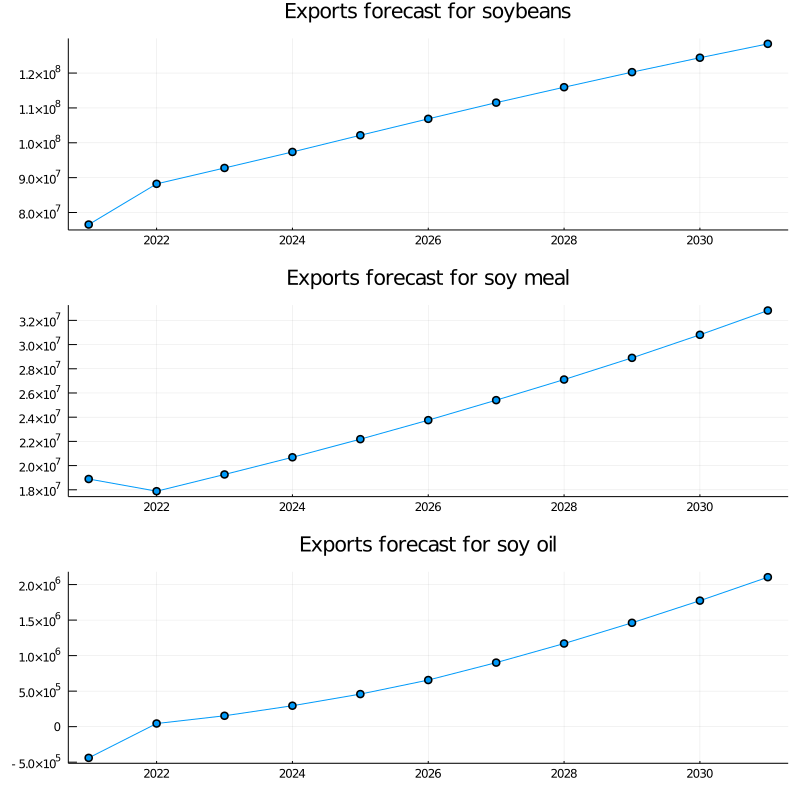

In [332]:
myPlots=[]
titles=["soybeans", "soy meal", "soy oil"]
for (i, c) in enumerate(eachcol(predictions))
   push!(myPlots, plot(collect(1:11).+2020,c, label=nothing, title="Exports forecast for $(titles[i])",
            marker=:circle))
end
plot(myPlots..., layout=(3,1), size=(800,800))